# Building with LangGraph

### Building a Chatbot

In [1]:
pip install -q openai langchain langchain-openai langchain-community langgraph


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from langgraph.graph import StateGraph
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI

In [3]:
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv(), override=True)

True

In [4]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")

graph = graph_builder.compile()

# Visualizing the Graph

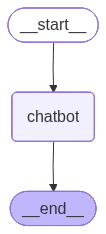

In [5]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
pip install -q grandalf


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
print(graph.get_graph().draw_ascii())

+-----------+  
| __start__ |  
+-----------+  
      *        
      *        
      *        
 +---------+   
 | chatbot |   
 +---------+   
      *        
      *        
      *        
 +---------+   
 | __end__ |   
 +---------+   


# Running the Chatbot

In [8]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "bye", "q"]:
        print("Goodbye!")
        break

    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print(f"Assistant: {value['messages'][-1].content}")
            print("-" * 20)

Assistant: It seems like your message might have been a mistake. How can I assist you today?
--------------------
Goodbye!


# Tavily AI

In [9]:
pip install -q tavily-python


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
from tavily import TavilyClient
import os

client = TavilyClient(api_key=os.environ.get("TAVILY_API_KEY"))

response = client.search(query="Qual o preço do bitcoin hoje?")
response

{'query': 'Qual o preço do bitcoin hoje?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.coingecko.com/pt-br/moedas/bitcoin',
   'title': 'Cotação do Bitcoin Hoje: BTC Preço e Gráfico em Tempo ...',
   'content': 'Como é calculado o preço de Bitcoin (BTC)? O preço de Bitcoin (BTC) é calculado em tempo real agregando-se os últimos dados de todas as 203 corretoras e 2845 mercados, utilizando uma fórmula de peso de volume global. ## Preço Bitcoin Hoje (BTC) ### Qual a capitalização de mercado de Bitcoin (BTC)? A capitalização de mercado de Bitcoin (BTC) é BTC19.956.365,0000 classificada em 1 na CoinGecko hoje. Com um preço declínio de - 3,60% nos últimos 7 dias, Bitcoin (BTC) é desempenho acima do normal a mercado de criptomoedas global que é para baixo - 4,30%. ## O preço de Bitcoin (BTC) caiu hoje. O preço de Bitcoin (BTC) é BTC1,0000 hoje, com um volume de negócios 24h de $86.966.584.572,21.',
   'score': 0.92125154,
   'raw_content': N

In [11]:
for result in response["results"]:
    print(f"Title: {result['title']}, URL: {result['url']}")

Title: Cotação do Bitcoin Hoje: BTC Preço e Gráfico em Tempo ..., URL: https://www.coingecko.com/pt-br/moedas/bitcoin
Title: Bitcoin (BTC) Price Today, URL: https://crypto.com/en/price/bitcoin
Title: Bitcoin hoje: Cotação, Valor e Preço! - Dolar Hoje, URL: https://dolarhoje.com/bitcoin-hoje/
Title: Preço de Bitcoin (BTC), URL: https://www.binance.com/pt/price/bitcoin
Title: Bitcoin hoje | Cotações e Gráficos de Bitcoin em Tempo Real, URL: https://www.novadax.com.br/bitcoin_real-hoje


In [ ]:
response = client.search(
    query="Quais são as melhores linguagens de programação para aprender esse ano?",
    search_depth="advanced",
    max_results=7,
    include_images=True,
    include_answer=True,
    include_raw_content=False,
)

response["answer"]

'As of 2025, Python, JavaScript, and C++ are highly recommended for learning due to their versatility and strong demand in the job market.'

In [13]:
answer = client.qna_search(query="When was tavily launched?")
print(answer)

Tavily was launched in 2023. It specializes in providing search APIs for AI agents. The company focuses on connecting AI agents to the web.


In [32]:
from langchain_classic.adapters.openai import convert_openai_messages
from langchain_openai import ChatOpenAI

query = 'What is the "Reflection & critique" pattern used in agentic applications and Langgraph'

response = client.search(query, max_results=5, search_depth="advanced")["results"]
response

[{'title': 'The Agentic Reflection Pattern: Teaching AI to Critique Itself',
  'url': 'https://jwinburndev.medium.com/the-agentic-reflection-pattern-teaching-ai-to-critique-itself-ac97631aa0e2',
  'content': 'The agentic reflection pattern is a workflow design where an AI system evaluates and critiques its own outputs, then uses that critique to generate improved versions. Instead of producing a single output and calling it done, the system engages in a cycle of generation, reflection, and refinement.\n\nThink of it like having a writer and an editor rolled into one, where the same intelligence plays both roles.\n\nThe basic flow looks like this: [...] \\\\Strategic Planning\\\\: Business applications use reflection to identify risks and gaps in proposed strategies before finalizing recommendations.\n\nThe Limitations\n\nLike any pattern, agentic reflection has boundaries:\n\n\\\\Diminishing Returns\\\\: After 2–3 iterations, improvements often become marginal. More cycles don’t necess

In [15]:
prompt = [
    {
        "role": "system",
        "content": """
You are an AI critical thinker research assistant.
           Your sole purpose is to write well written, objective and structured reports on given text
""",
    },
    {
        "role": "user",
        "content": f'''Information """{response}"""
        Using the above information answer the following query: """{query}""" in a detailed report
        ''',
    },
]

lc_messages = convert_openai_messages(prompt)
lc_messages

[SystemMessage(content='\nYou are an AI critical thinker research assistant.\n           Your sole purpose is to write well written, objective and structured reports on given text\n', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='Information """[{\'title\': \'The Agentic Reflection Pattern: Teaching AI to Critique Itself\', \'url\': \'https://jwinburndev.medium.com/the-agentic-reflection-pattern-teaching-ai-to-critique-itself-ac97631aa0e2\', \'content\': \'The agentic reflection pattern is a workflow design where an AI system evaluates and critiques its own outputs, then uses that critique to generate improved versions. Instead of producing a single output and calling it done, the system engages in a cycle of generation, reflection, and refinement.\\n\\nThink of it like having a writer and an editor rolled into one, where the same intelligence plays both roles.\\n\\nThe basic flow looks like this: [...] \\\\\\\\Strategic Planning\\\\\\\\: Business applications use

In [ ]:
response = ChatOpenAI(model="gpt-4o-mini").invoke(lc_messages)
print(response.content)

content='# Report on the "Reflection & Critique" Pattern in Agentic Applications and LangGraph\n\n## Introduction\nThe "Reflection & Critique" pattern is a prominent concept in the design and operation of artificial intelligence (AI) systems, specifically within agentic applications and tools like LangGraph. This iterative framework allows AI models, particularly large language models (LLMs), to enhance their performance through self-assessment and refinement of generated outputs. In essence, the pattern embodies the dual roles of creator and critic within the same system, facilitating continuous improvement in decision-making and output quality.\n\n## Overview of the Reflection & Critique Pattern\n\n### Definition\nThe Reflection & Critique pattern is characterized by a cyclical process where an AI model:\n1. **Generates Initial Output**: The AI creates an output based on a given prompt or task.\n2. **Self-Evaluation**: The AI then evaluates its output for quality, coherence, correctn

# Enhancing the Chatbot with Tools

In [17]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=3)
tools = [tool]

/tmp/ipykernel_2807/2191939325.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tool = TavilySearchResults(max_results=3)


In [18]:
response = tool.invoke("O que é GPT o1?")
response

[{'title': 'GPT o1: qué es y diferencias, y cómo acceder al nuevo modelo de ...',
  'url': 'https://www.xataka.com/basics/gpt-o1-que-diferencias-como-acceder-al-nuevo-modelo-inteligencia-artificial-chatgpt',
  'content': 'GPT o1 es un nuevo modelo de inteligencia artificial creado por OpenAI. GPT es el nombre de los modelos que hay debajo de ChatGPT. Es la tecnología que estos bots de inteligencia artificial utilizan, y hay distintas versiones disponibles. Vamos, que ChatGPT solo es un bot, un entorno con el que tú puedes hacerle preguntas, y luego él utiliza su motor GPT para entenderte y generar la respuesta. [...] ## Las diferencias de GPT o1\n\nComo te hemos explicado GPT o1 funciona de una manera totalmente diferente a los modelos anteriores. No prioriza la velocidad de las respuestas, sino que se toma más tiempo para poder analizar los datos y generar una respuesta más correcta. [...] Vamos a empezar el artículo explicándote qué es exactamente GPT o1 en concreto, y este tipo de m

In [19]:
from langgraph.graph import StateGraph
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges("chatbot", tools_condition)

graph_builder.add_edge("tools", "chatbot")

graph_builder.set_entry_point("chatbot")
# graph_builder.set_finish_point("chatbot")

graph = graph_builder.compile()


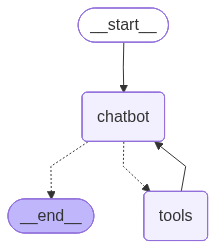

In [20]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "bye", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant: ", value["messages"][-1])

        print("-" * 50)


Assistant:  content='' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 90, 'total_tokens': 117, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b547601dbd', 'id': 'chatcmpl-CiQ3QoyUrhxlH7k7CjI47GTkjob7n', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='lc_run--2702b4d9-bcb8-4102-b7c1-d063d020fdf8-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'swimming gold medal winner Paris Olympics 2024'}, 'id': 'call_QL0YsNza7s65s2r7t6CzT9Qu', 'type': 'tool_call'}] usage_metadata={'input_tokens': 90, 'output_tokens': 27, 'total_tokens': 117, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 

# Adding memory to the Chatbot

In [33]:
pip install -q langgraph-checkpoint-sqlite


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [34]:
from langgraph.graph import StateGraph
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges("chatbot", tools_condition)

graph_builder.add_edge("tools", "chatbot")

graph_builder.set_entry_point("chatbot")
# graph_builder.set_finish_point("chatbot")

graph = graph_builder.compile()


In [ ]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.memory import MemorySaver

memory = SqliteSaver.from_conn_string(":memory:")

graph = graph_builder.compile(checkpointer=MemorySaver())

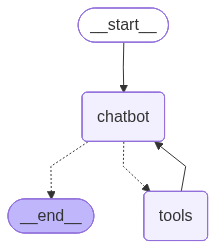

In [36]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [43]:
config = {"configurable": {"thread_id": "1"}}

In [44]:
prompt = "Hi my name is andre and you are a math tutor"
events = graph.stream({"messages": [("user", prompt)]}, config, stream_mode="values")

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi my name is andre and you are a math tutor
================================== Ai Message ==================================

Hi Andre! Yes, I'm here to help you with math. What specific math topics or questions do you have?


In [45]:
prompt = "What is my name? What is your role?"

events = graph.stream({"messages": [("user", prompt)]}, config, stream_mode="values")

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is my name? What is your role?
================================== Ai Message ==================================

Your name is Andre, and my role is to be your math tutor. How can I assist you today?


In [46]:
config1 = {"configurable": {"thread_id": "2"}}

In [47]:
events = graph.stream({"messages": [("user", prompt)]}, config1, stream_mode="values")

for event in events:
    event["messages"][-1].pretty_print()


================================ Human Message =================================

What is my name? What is your role?
================================== Ai Message ==================================

I don't have access to personal information about users, including names, unless you share that information with me. My role is to assist you by providing information, answering questions, and helping with various tasks to the best of my ability. How can I assist you today?


In [48]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi my name is andre and you are a math tutor', additional_kwargs={}, response_metadata={}, id='9381ff92-8c8e-43ad-aa14-e1dcf80e0c2c'), AIMessage(content="Hi Andre! I'm here to help you with math. What specific topics or questions do you have in mind?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 90, 'total_tokens': 113, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b547601dbd', 'id': 'chatcmpl-CiQqLtnFTMCkiyuphStZ9W9wGzFMk', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--2bf63d78-3c29-46d3-98d5-f2afff913fb4-0', usage_metadata={'input_tokens': 90, 'output_tokens': 23, 'total_to

In [50]:
snapshot.next

()